### Part 1: Data Reading and Exploration

In [1]:
# basic imports
import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from IPython.display import HTML
from collections import defaultdict
from sklearn.model_selection import ParameterGrid
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook as tqdm
from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
df = pd.read_csv('clustering_dataset.csv')

In [3]:
df['Delay_m'] = df.Delay_s/60

In [4]:
df.head()

,StopNumber,MonitoredVehicleJourney_DirectionRef,DistanceTraveled_km,Delay_s,EarlyCount,DelayCount,OnTimeCount,Delay_s_per_km,Delay_m
0,8,I,2.5780,44.536482,3356,6428,8595,17.275594,0.742275
1,12,I,1.2108,43.395680,9633,18330,25464,37.178352,0.723261
2,14,I,0.5738,85.787101,13849,28756,18222,153.858460,1.429785
3,14,O,0.5360,0.000000,187,522,5268,0.000000,0.000000
4,15,I,0.7226,87.510760,12117,24862,12880,121.105398,1.458513


In [5]:
# an insight into the data
df.describe()

,StopNumber,DistanceTraveled_km,Delay_s,EarlyCount,DelayCount,OnTimeCount,Delay_s_per_km,Delay_m
count,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000,749.000000
mean,2293.436582,0.814913,35.028986,3136.160214,6735.244326,13373.662216,88.774506,0.583816
std,1840.875408,1.026998,45.183535,3191.390441,6234.056134,10532.647385,148.372124,0.753059
min,8.000000,0.105900,-135.543103,0.000000,0.000000,10.000000,-221.910778,-2.259052
25%,847.000000,0.269900,0.000000,518.000000,1586.000000,4577.000000,0.000000,0.000000
50%,1656.000000,0.399800,19.443862,1977.000000,4334.000000,10533.000000,21.228423,0.324064
75%,3584.000000,0.986100,60.293801,5031.000000,10787.000000,19652.000000,108.844556,1.004897
max,7671.000000,9.085000,197.450820,14966.000000,34055.000000,46252.000000,1063.535257,3.290847


The values from standard deviation show that the data is skewed, let's do some plots to check it out.

In [6]:
df.drop('Delay_m', axis=1, inplace=True)

In [7]:
plt.rcParams["figure.figsize"] = (16, 12)

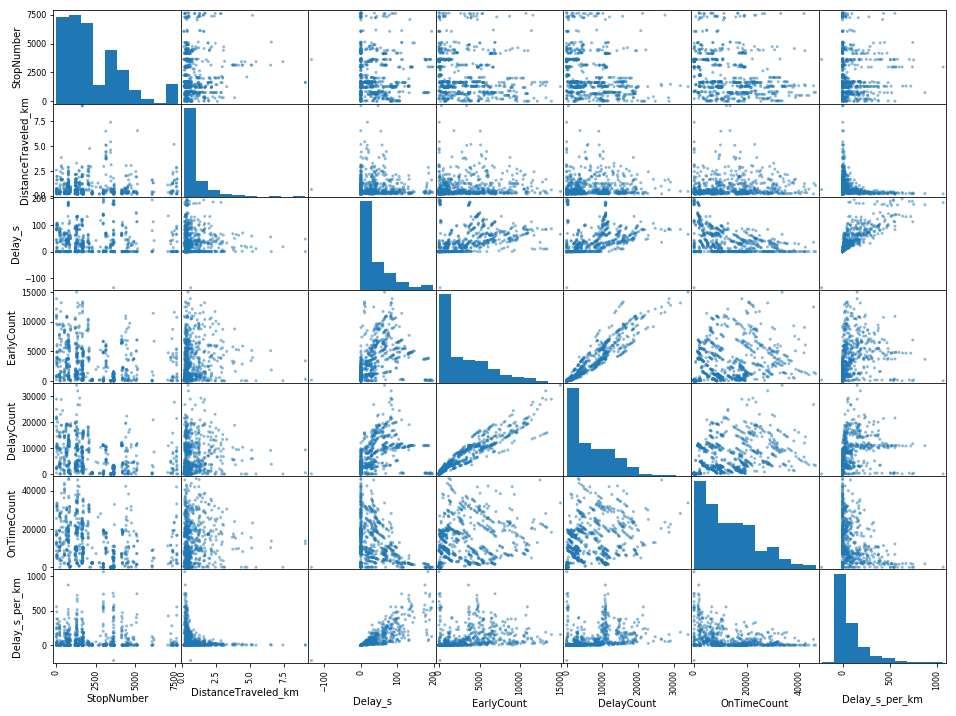

In [8]:
# create a pairwise plot
pd.plotting.scatter_matrix(df, zorder=2);

We ere correct. There are skewness that can be addressed by Standardizing. However we want to capture the effect of outliers also. For the bivariate data, we can also see some clear trends. We can explore them after clustering.

### Part 2: Feature engineering

Since the data has outliers, we need to standardize it. Among the standard procedures of scaling we choose standardization because it makes the data scaled with mean 0 and standard deviation 1. This is proved to work well with PCA which seeks the direction that maximizes the variance and hence improving clustering algorithms like k-means.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


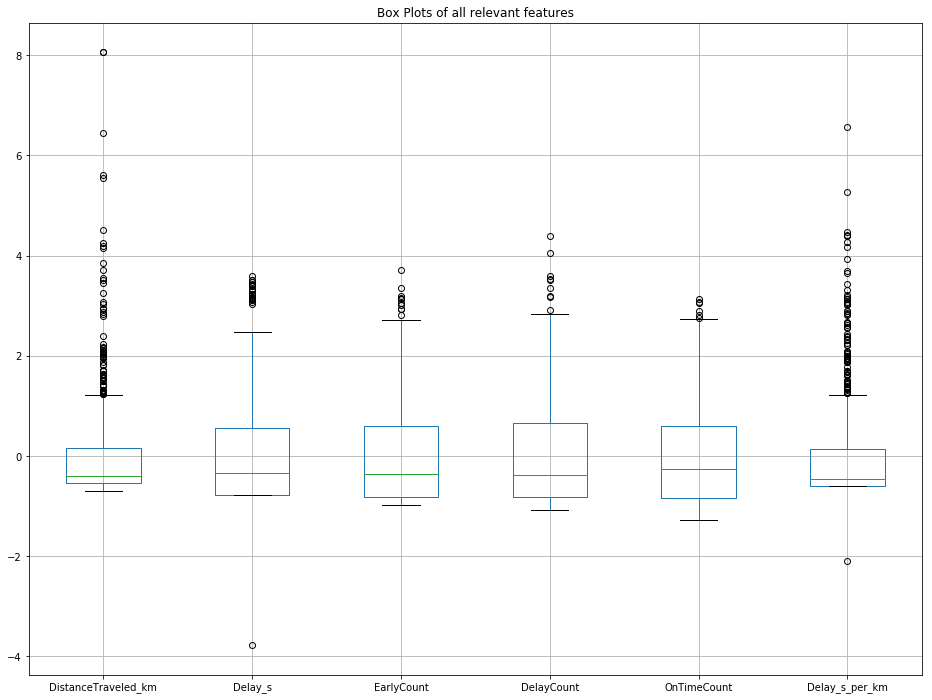

In [9]:
# divide the data into training set for passing it for transformations
train = df.iloc[:,2:]

# fit the training set
scaler = StandardScaler().fit(train)
# transfomr the dataset based on the scaler model
train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns)
# creating a boxplot to validate the outcome
train_scaled.boxplot();
plt.title("Box Plots of all relevant features");

The data seems to be standardized and the box-plot proves it. However we still have outliers (the dots), but we won't perform any outliers treatment like capping as it may negate it's effects in clustering.

### Part 3: Dimensionality Reduction and Clustering

#### KMeans

Now it is known that data with high dimension may be a problem for clustering which uses Euclidean Distance. Let's try to find an optimal PCA component value to before deep diving into clustering.

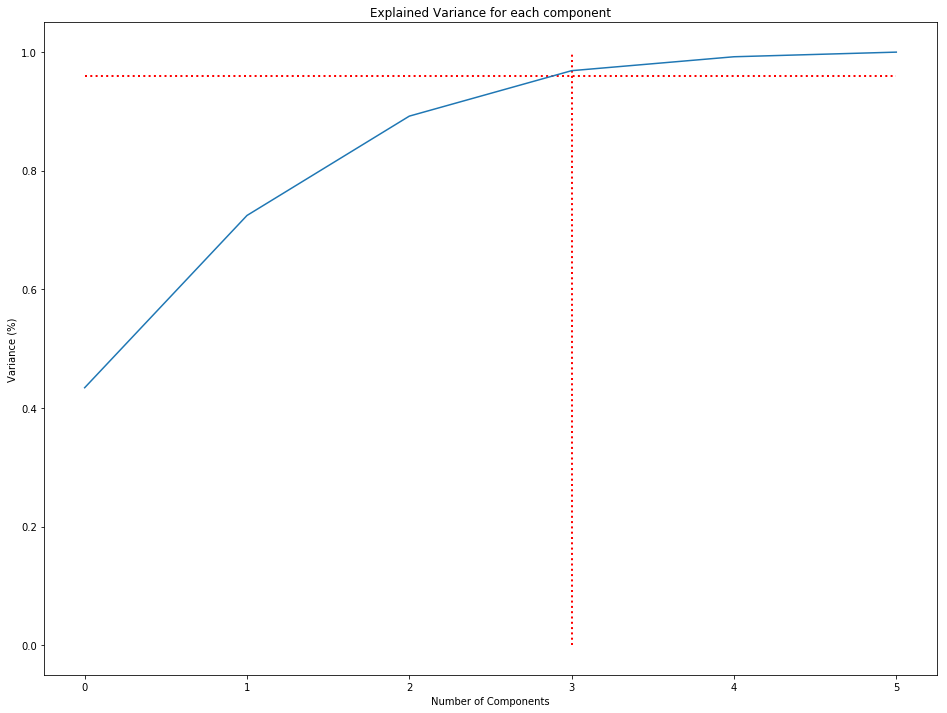

In [10]:
# fitting the pca model on the scaled data
pca = PCA().fit(train_scaled)

# plotting the Cumulative Summation of the Explained Variance
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_))
# plot the guiding lines to find the optimum number of pca components
ax.hlines(y=0.96, xmin=0, xmax=5, linewidth=2, color='r', linestyle="dotted")
ax.vlines(x=3, ymin=0, ymax=1, linewidth=2, color='r', linestyle="dotted")
# setting the plot labels and title
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance for each component')
plt.show()

We can conclude that 3 dimensions will explain the variance without bias. So, number of components as 3 will be a good measure.

However, we may try to incorporate a step clustering mechanism to choose the important features without transforming them via PCA. We can compare the results and carry on.

But before that, let's try to choose the number of clusters using elbow and taking the PCA transformed dataframe for it.

In [11]:
# transforming the dataset based on the pca model with 4 components
pca = PCA(n_components=3)
train_pca = pca.fit_transform(train_scaled)

In [12]:
sse = {}
# we will take cluster number from 1 to 50 and perform clustering while noting down the standard squared error
for k in tqdm(range(1, 50)):
    kmeans_elbow = KMeans(n_clusters=k, verbose=False).fit(train_scaled)
    # inertia is sum of distances of samples to their closest cluster center
    sse[k] = kmeans_elbow.inertia_

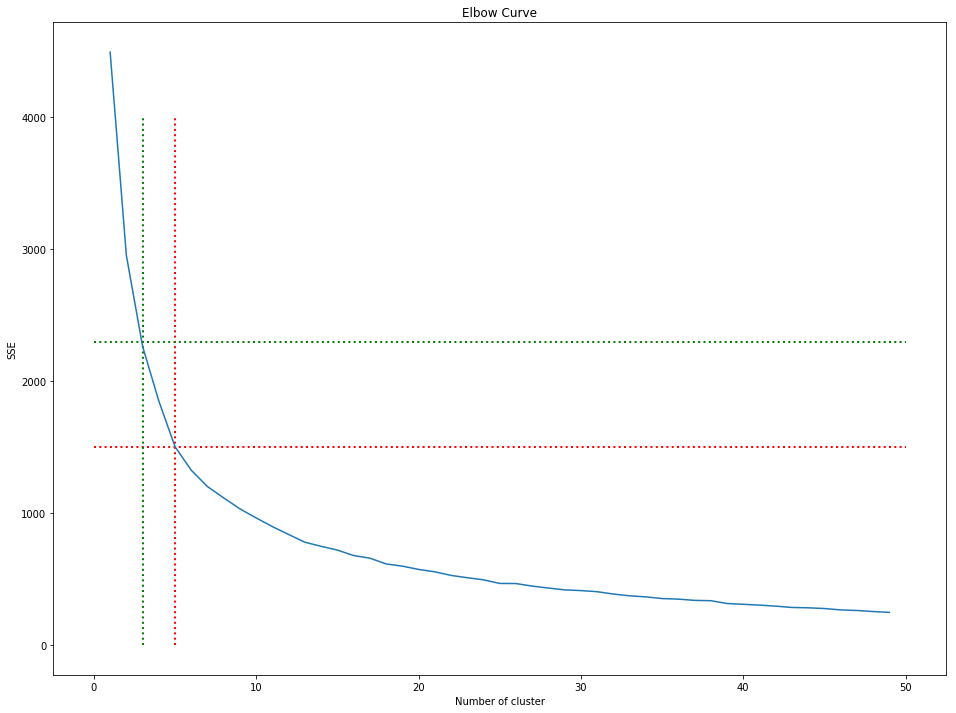

In [13]:
# plotting the SSE
fig, ax = plt.subplots()
ax.plot(list(sse.keys()), list(sse.values()))

# plotting the guidelines to find the optimum number of clusters
ax.hlines(y=1500, xmin=0, xmax=50, linewidth=2, color='r', linestyle="dotted")
ax.vlines(x=5, ymin=0, ymax=4000, linewidth=2, color='r', linestyle="dotted")

ax.hlines(y=2300, xmin=0, xmax=50, linewidth=2, color='g', linestyle="dotted")
ax.vlines(x=3, ymin=0, ymax=4000, linewidth=2, color='g', linestyle="dotted")

# setting the plot labels and title
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("Elbow Curve")
plt.show()

We can say that 5 clusters is making an optimal SSE without bias. However, from business point of view, we may need only 3 clusters. Although that accounts for a slightly bad SSE, we'll go for it.

In [14]:
# fitting the kmeans model with 5 clusters
kmeans = KMeans(n_clusters=3, random_state=420).fit(train_pca)
# getting the silhouette score
score = silhouette_score(train_pca, kmeans.labels_)
print(score)

0.4350984991698866


That seems to be a pretty low score. We can try step-clustering to see which components are performing best.

In [15]:
# define the lists to capture best features
best_features_steps = []
best_features = set()

# score dict to store the scores
score_dict = defaultdict()
best = None
max_score = 0

# iterate through all the columns of interest
for i in range(len(df.columns)-1):
    local_score = []
    # pick column not already selected and test it's membership
    for test in set(train.columns):
        
        # if column is already a member skip it and try with the next column
        if test in best_features:
            continue
        
        # fit the kmeans model with the member columns and the test column and get the score
        kmeans = KMeans(n_clusters=8, random_state=420).fit(train_scaled[[test]])
        score = silhouette_score(train_scaled[[test]+list(best_features)], kmeans.labels_)

        # store the scores for finding the minimum to set it as a baseline for the next iteration
        local_score.append(score)
        score_dict[tuple(train[[test]+list(best_features)])] = score
        
        # if it beats the best score, store it
        if score > max_score:
            max_score = score
            best = test
           
    # store the best features
    best_features = best_features.union({best})
    best_features_steps += [list(best_features)]
    
    # make the baseline score for the next iteration as minimum score of the present run
    max_score = min(local_score)

In [16]:
# get the scores and the selected columns in sorted way
pd.DataFrame(sorted(score_dict.items(), key=lambda kv: kv[1], reverse=True)[:15], columns=['columns', 'score'])

,columns,score
0,"(Delay_s,)",0.739799
1,"(Delay_s_per_km,)",0.697673
2,"(DistanceTraveled_km,)",0.614331
3,"(DelayCount,)",0.602181
4,"(EarlyCount,)",0.598546
5,"(OnTimeCount,)",0.582613
6,"(Delay_s_per_km, Delay_s)",0.421201
7,"(DelayCount, Delay_s)",0.120881
8,"(DistanceTraveled_km, Delay_s)",0.094846
9,"(OnTimeCount, Delay_s)",0.087190


We can see that the singleton set 'Delay_s' is having the best silhouette score. That is the more dimension we introduce the bad it becomes. Let's try to get a baseline score on the actual raw data with PCA transformation.

In [17]:
# define the model with components as 3
pca = PCA(n_components=3)
# transform the dataset
df_pca = pd.DataFrame(pca.fit_transform(df.iloc[:,2:]))

In [18]:
# fit the kmeans model on the pca transformed dataset
kmeans = KMeans(n_clusters=3, random_state=420).fit(df_pca)
# get the score
score = silhouette_score(df_pca, kmeans.labels_)
print(score)

0.36563088863188375


We can conclude that standardization is making the dataset to lose information. So, we'll stick to the **original values** and **not on the standardized one** to find the clusters.

#### KMeans

In [19]:
# defining a global kmeans model
kmeans = KMeans(n_clusters=3, random_state=420).fit(train_pca)
# create a new column with the cluster numbers as per the kmeans model
df['cluster_kmeans'] = kmeans.labels_

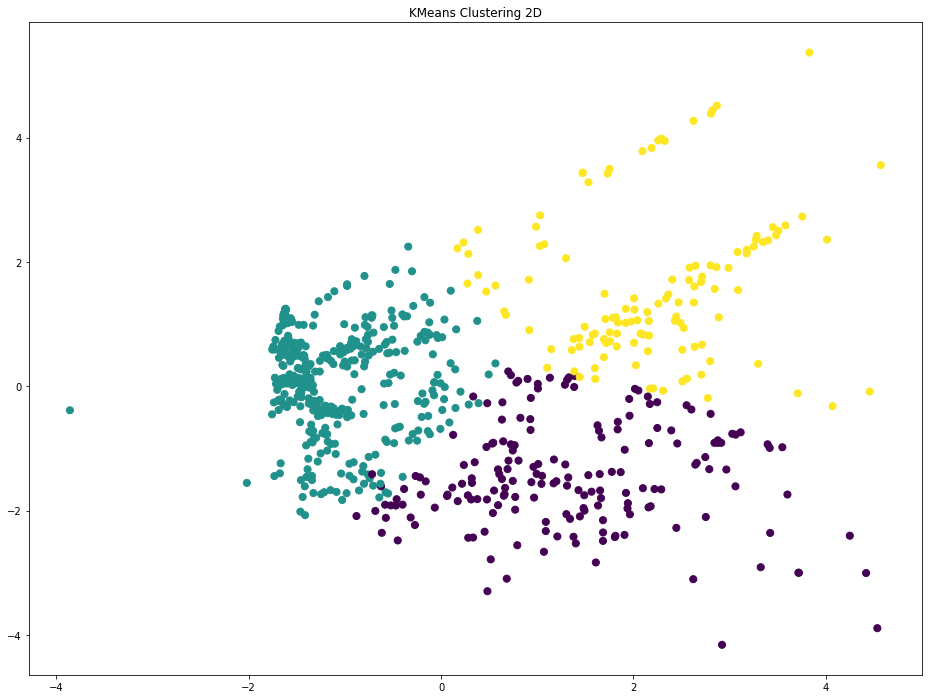

In [20]:
# create 2d dataset using pca for plotting
temp = pd.DataFrame(PCA(n_components=2).fit_transform(train_scaled))
# plot the 2d points with color as cluster number
plt.scatter(temp.iloc[:,0], temp.iloc[:,1], c=df.cluster_kmeans.tolist(), s=50, cmap='viridis');
plt.title("KMeans Clustering 2D");

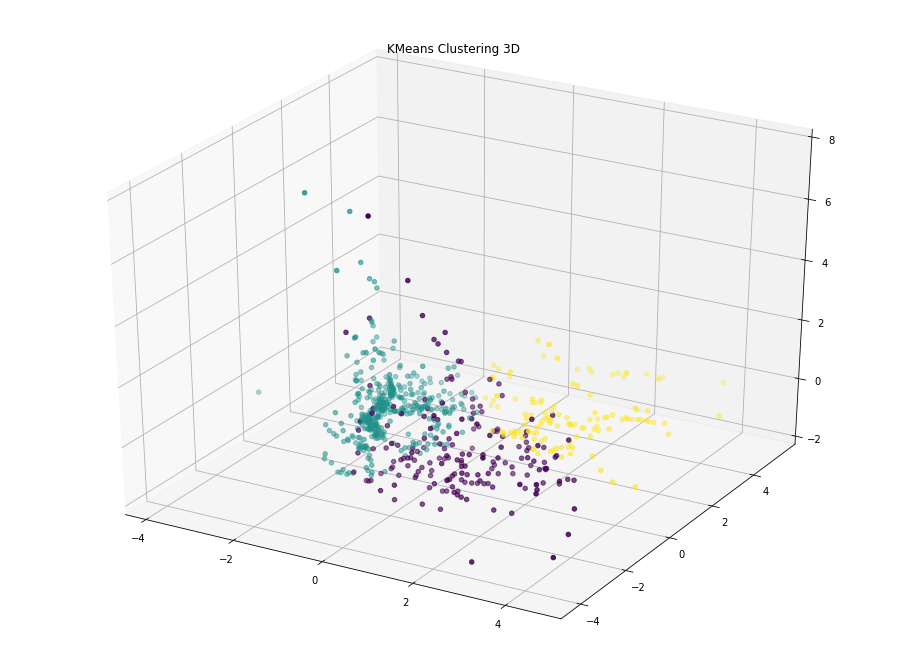

In [21]:
# create a 3d plot
# create 3d dataset using pca for plotting
temp = pd.DataFrame(PCA(n_components=3).fit_transform(train_scaled))
# plot the 2d points with color as cluster number
ax = plt.axes(projection = '3d')
ax.scatter(temp.iloc[:,0], temp.iloc[:,1], temp.iloc[:,2], c=df.cluster_kmeans.tolist(), cmap='viridis');
plt.title("KMeans Clustering 3D");

In [22]:
# get the score
score = silhouette_score(train_pca, df.cluster_kmeans.tolist())
print(score)

0.4350984991698866


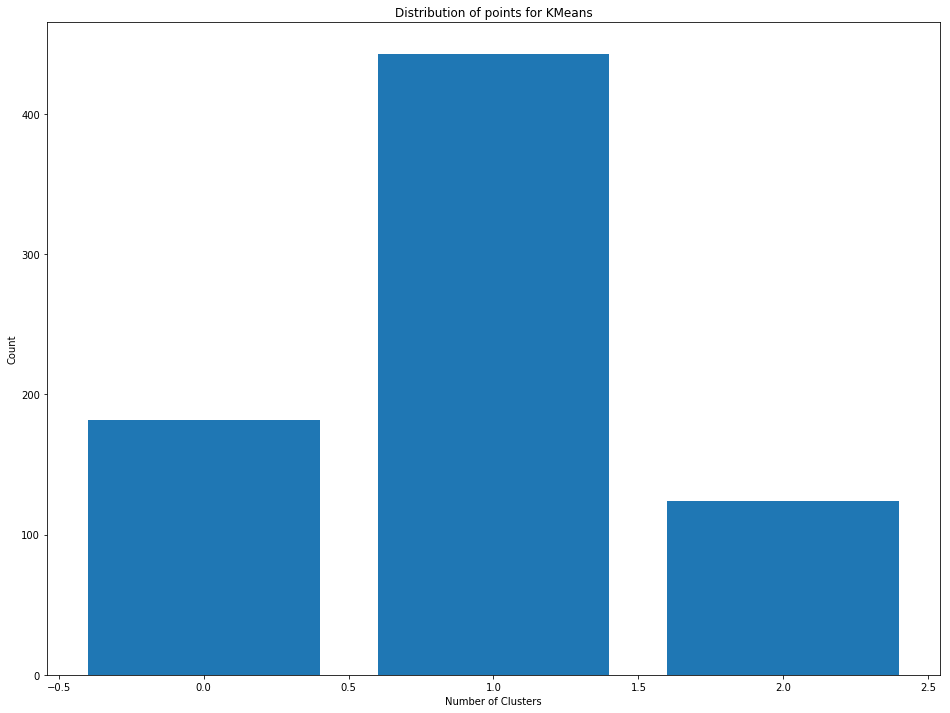

In [23]:
# get the count of countries in each cluster
cluster_dist = pd.DataFrame(df.cluster_kmeans.value_counts())
cluster_dist.reset_index(inplace=True)
# plot the counts per cluster
cluster_dist.columns = ['cluster_number', 'counts']
plt.bar(cluster_dist.cluster_number, cluster_dist.counts);

# setting the plot labels and title
plt.xlabel("Number of Clusters");
plt.ylabel("Count");
plt.title("Distribution of points for KMeans");

The membership distribution seems good. Now, once we have benchmarked the values and processing for K-Means, let's try out once more algorithm - DBScan.

#### DBScan

In [24]:
# create a grid search dictionary
grid_dict = {}
# define the parameters for grid search
grid = {
    'eps': np.arange(0.01, 10, 0.5),
    'min_samples' : range(1,30)
}
# for each parameter, perform a search and store the score
for g in ParameterGrid(grid):
    # hanndle error in case a singleton cluster, score cannot be calculated
    try:
        # fit the dbscan model
        dbscan = DBSCAN().set_params(**g).fit(train_pca)
        # get the score
        score = silhouette_score(train_scaled, dbscan.labels_)
        # store the score
        if len(np.unique(dbscan.labels_)) == 3:
            grid_dict[tuple(g.items())+('cluster_size', len(np.unique(dbscan.labels_)))] = score
    except Exception as e:
        pass

In [25]:
# the parameters for the best scores
pd.DataFrame(sorted(grid_dict.items(), key=lambda kv: kv[1], reverse=True)[:15], columns=['params', 'score'])

,params,score
0,"((eps, 1.01), (min_samples, 5), cluster_size, 3)",0.418456
1,"((eps, 1.01), (min_samples, 6), cluster_size, 3)",0.417368
2,"((eps, 1.01), (min_samples, 7), cluster_size, 3)",0.407575
3,"((eps, 1.01), (min_samples, 9), cluster_size, 3)",0.402477
4,"((eps, 1.01), (min_samples, 8), cluster_size, 3)",0.402096
5,"((eps, 1.01), (min_samples, 10), cluster_size, 3)",0.398772
6,"((eps, 1.01), (min_samples, 11), cluster_size, 3)",0.398772
7,"((eps, 1.01), (min_samples, 12), cluster_size, 3)",0.396718
8,"((eps, 1.01), (min_samples, 13), cluster_size, 3)",0.374441
9,"((eps, 1.01), (min_samples, 14), cluster_size, 3)",0.374441


In [26]:
# create a global dbscan model
dbscan = DBSCAN(eps=1.01, min_samples=5)
# store the cluster numbers of dbscan model in the dataset
temp = pd.DataFrame(PCA(n_components=3).fit_transform(train_pca))
df['cluster_dbscan'] = dbscan.fit(temp).labels_

Text(0.5, 1.0, 'DBScan Clustering')

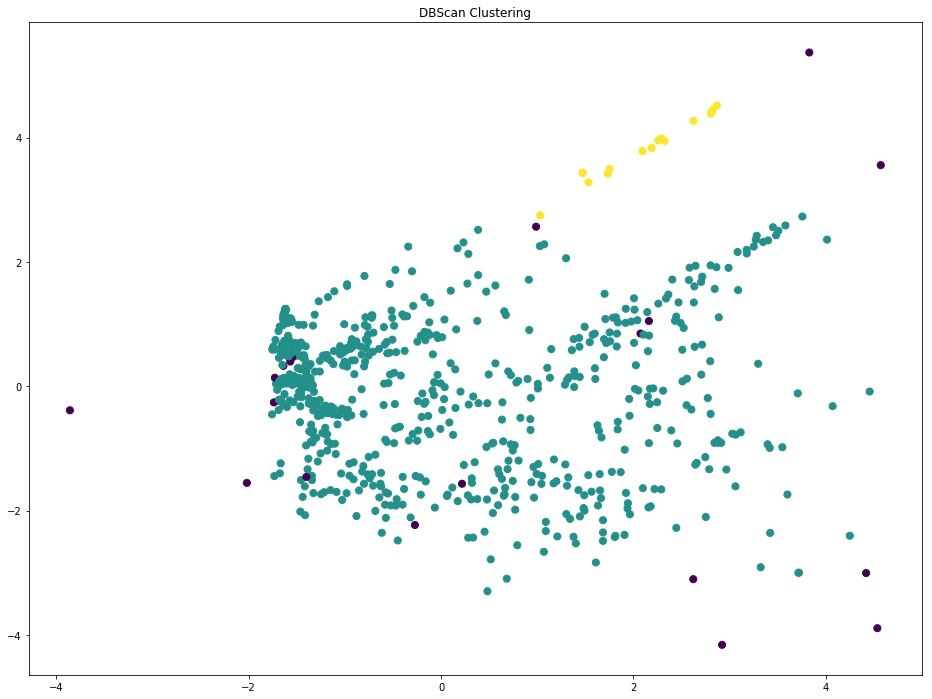

In [27]:
# create 2d dataset using pca for plotting
temp = pd.DataFrame(PCA(n_components=2).fit_transform(train_scaled))
# plot the 2d pca values with color as cluster number
plt.scatter(temp.iloc[:,0], temp.iloc[:,1], c=df.cluster_dbscan.tolist(), s=50, cmap='viridis');
plt.title("DBScan Clustering")

In [28]:
# get the score
score = silhouette_score(train_pca, df.cluster_dbscan.tolist())
print(score)

0.3928533852951988


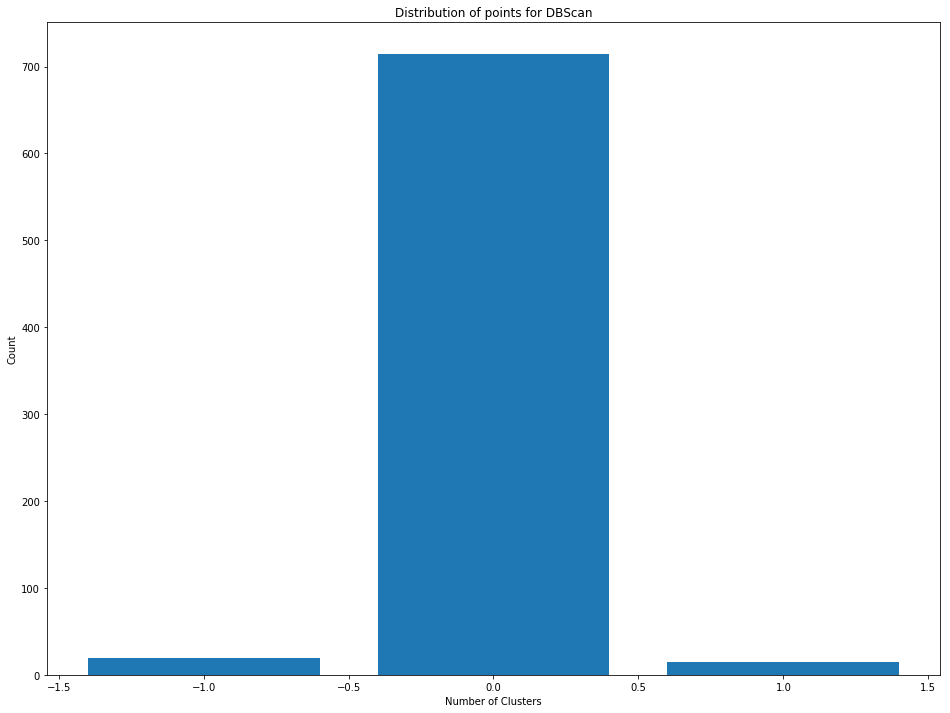

In [29]:
# get the count of countries in each cluster
cluster_dist = pd.DataFrame(df.cluster_dbscan.value_counts())
cluster_dist.reset_index(inplace=True)
# plot the counts per cluster
cluster_dist.columns = ['cluster_number', 'counts']
plt.bar(cluster_dist.cluster_number, cluster_dist.counts);

# setting the plot labels and title
plt.xlabel("Number of Clusters");
plt.ylabel("Count");
plt.title("Distribution of points for DBScan");

However we seem to have a better distribution of the points across clusters and better benchmarking score with KMeans. So, we'll go with it till now.

#### Hierarchical Clustering

We will create two dendrograms, one on the the scaled data and the other one on the raw data

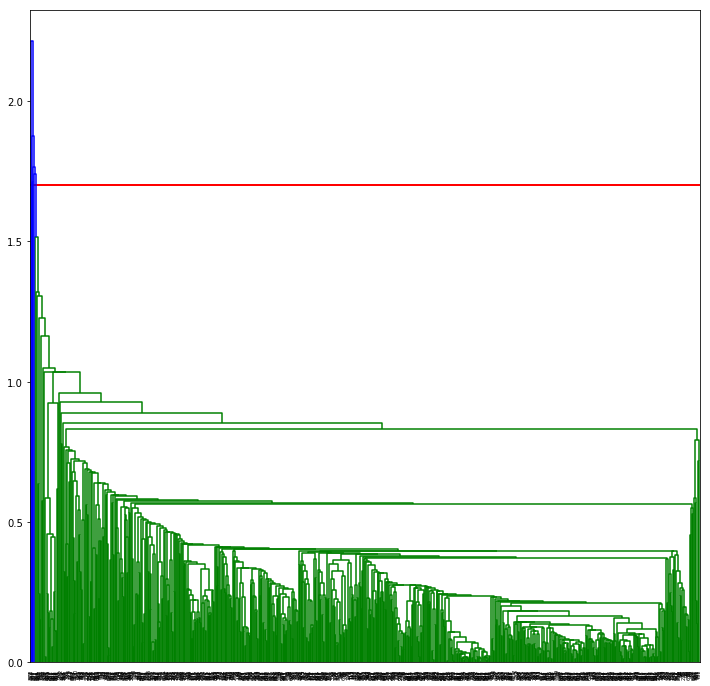

In [30]:
# dendrogram on scaled data
Z = linkage(train_pca)

# plot the dendograms
plt.figure(figsize=(12,12))
# plot the threshold cut line
plt.hlines(1.7, xmin=0, xmax=500000, linewidth=2, color='r')
dendrogram(Z, leaf_rotation=90.);

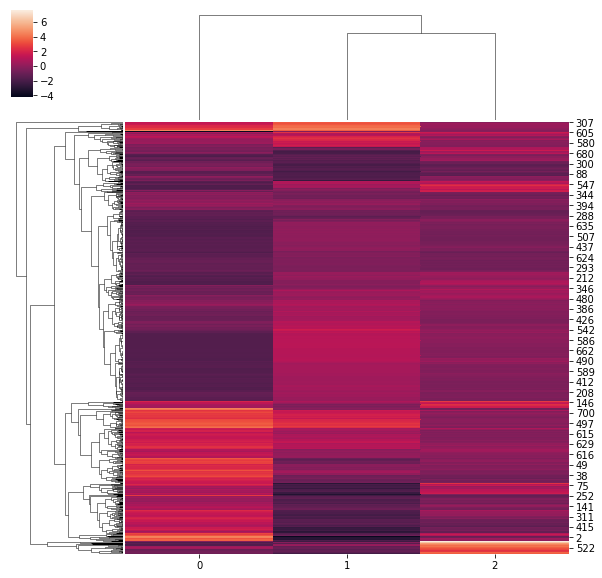

In [31]:
# creating heatmap
sns.clustermap(train_pca);

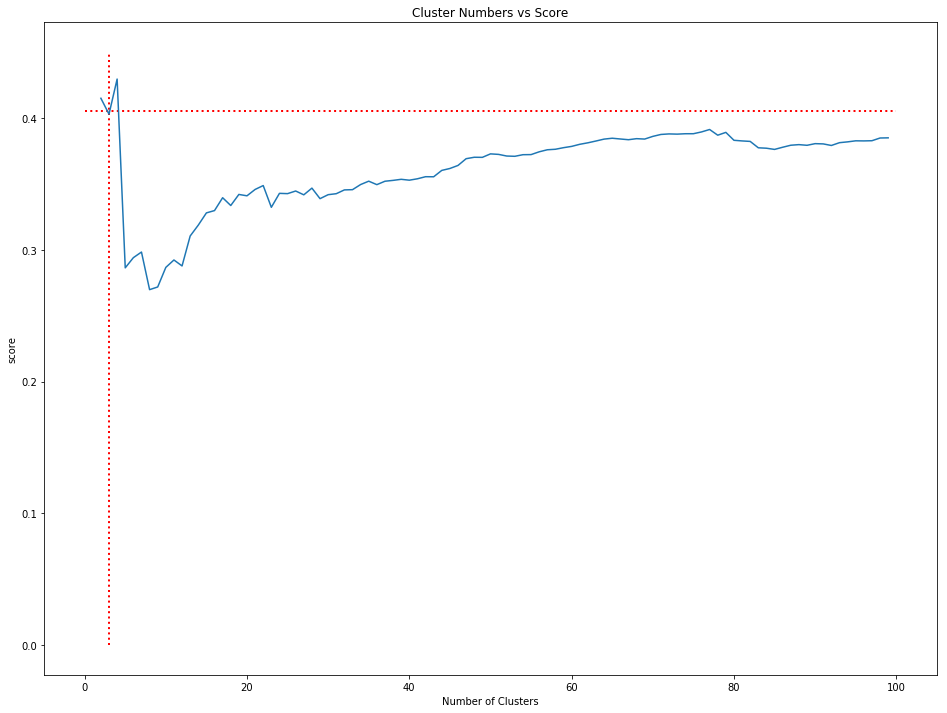

In [32]:
# plotting the score vs number of clusters
x = []
y = []
# iterating through 2 to 100 clusters
for i in range(2,100):
    # fit the hierarchical model with the number of clusters
    hcluster = AgglomerativeClustering(n_clusters=i)
    # store the number of clusters
    hcluster = hcluster.fit(train_pca)
    x.append(i)
    # store the scores
    y.append(silhouette_score(train_pca, hcluster.labels_))
    
#plot the cluster number and score
plt.plot(x,y);
plt.hlines(y=0.405, xmin=0, xmax=100, linewidth=2, color='r', linestyle="dotted")
plt.vlines(x=3, ymin=0, ymax=0.45, linewidth=2, color='r', linestyle="dotted")
plt.title('Cluster Numbers vs Score');
plt.xlabel('Number of Clusters');
plt.ylabel('score');

So, as we can see from the plot the score is increasing as we increase the number of clusters. It does not make any sense from business point of view. Let's go with the standardized version of the dataset.

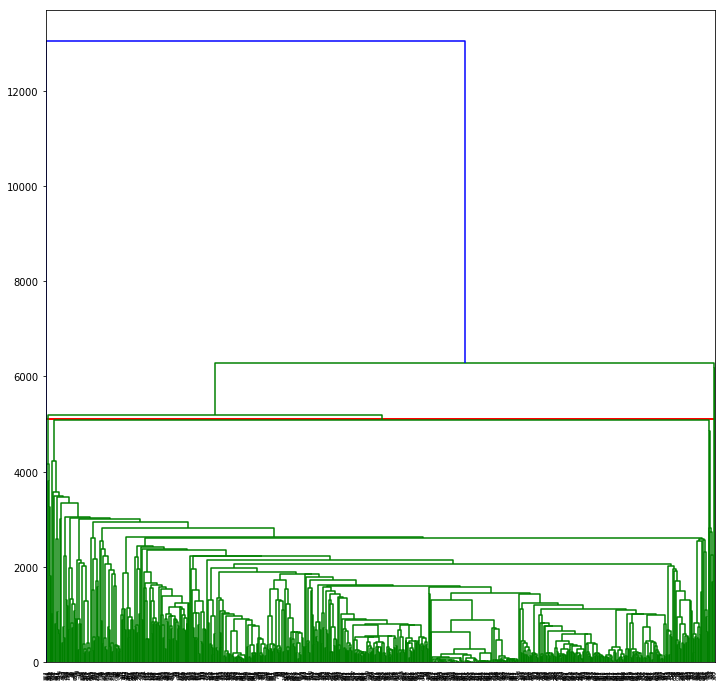

In [33]:
# dendrogram on the pca version of data (not scaled)
Z = linkage(df_pca)
plt.figure(figsize=(12,12))
# plot the guideline for cut treshold
plt.hlines(5100, xmin=0, xmax=500000, linewidth=2, color='r')
dendrogram(Z, leaf_rotation=90.);

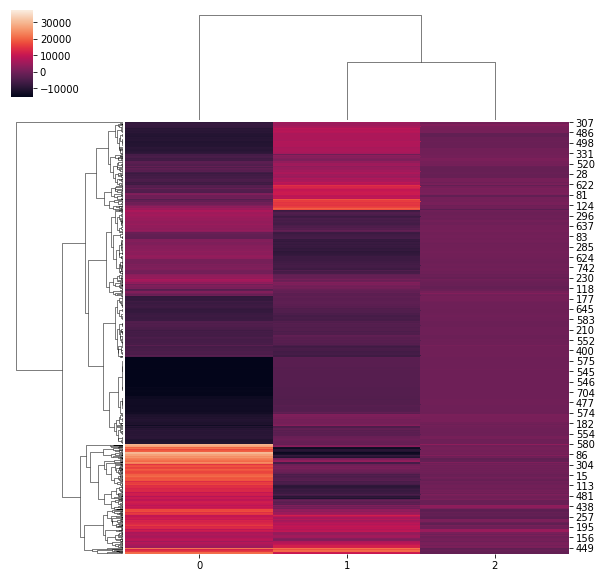

In [34]:
# creating heatmap
sns.clustermap(df_pca);

Text(0, 0.5, 'score')

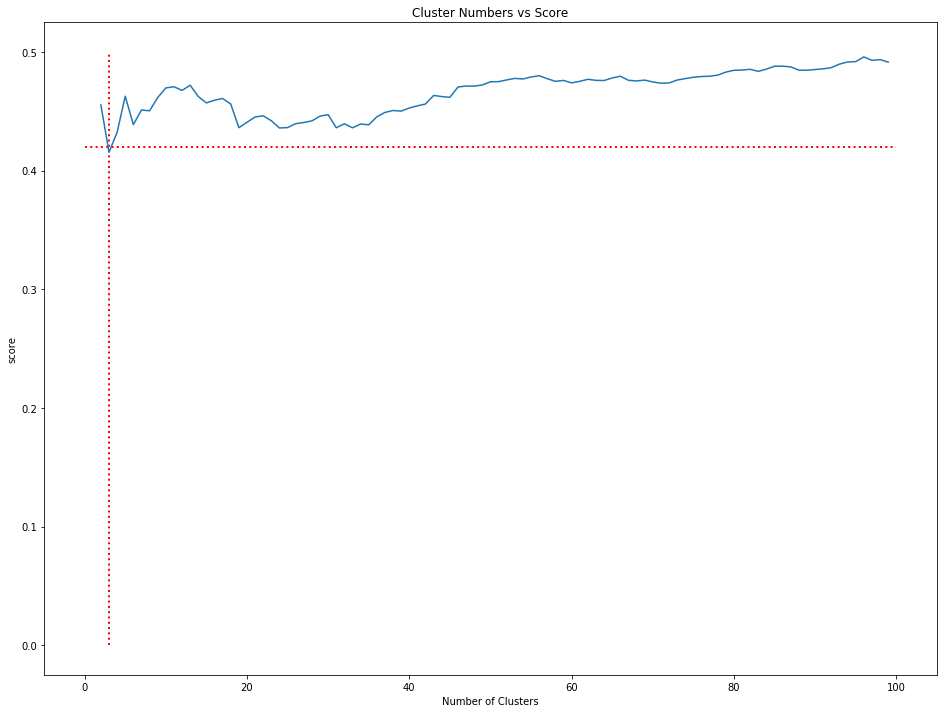

In [35]:
# plotting the score vs number of clusters
x = []
y = []
# iterating through two to hundred clusters
for i in range(2,100):
    # fitting the hierarchical clustering model based on the selected number
    hcluster = AgglomerativeClustering(n_clusters=i)
    hcluster = hcluster.fit(df_pca)
    #store the cluster number and store the score
    x.append(i)
    y.append(silhouette_score(df_pca, hcluster.labels_))
# plot the cluster number and score
plt.plot(x,y)
plt.hlines(y=0.42, xmin=0, xmax=100, linewidth=2, color='r', linestyle="dotted")
plt.vlines(x=3, ymin=0, ymax=0.5, linewidth=2, color='r', linestyle="dotted")
plt.title('Cluster Numbers vs Score')
plt.xlabel('Number of Clusters')
plt.ylabel('score')

In [36]:
# fitting the hierarchical cluster with number of clusters as five on the pca transformed data
hcluster = AgglomerativeClustering(n_clusters=3)
hcluster = hcluster.fit(df_pca)

# storing the clusters for hierarchical clustering in the dataframe
df['cluster_hierarchical'] = hcluster.fit(df_pca).labels_

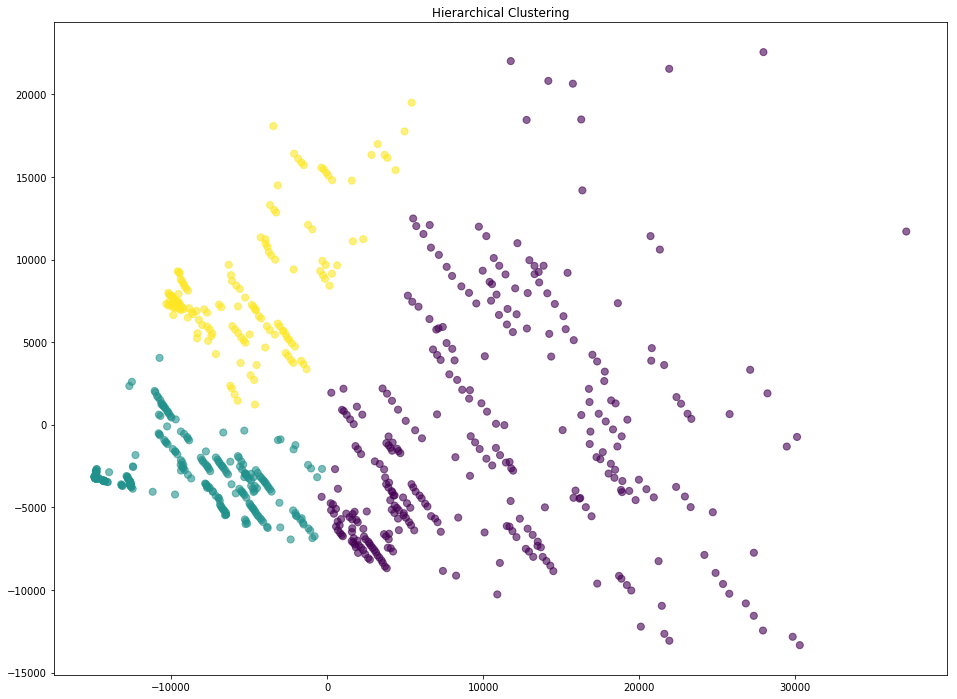

In [37]:
# plotting the clusters for hierarchical clustering
temp = pd.DataFrame(PCA(n_components=2).fit_transform(df_pca))
plt.scatter(temp.iloc[:,0], temp.iloc[:,1], c=df.cluster_hierarchical.tolist(), s=50, cmap='viridis', alpha=0.6)
plt.title("Hierarchical Clustering");

In [38]:
# get the score
score = silhouette_score(df_pca, df.cluster_hierarchical.tolist())
print(score)

0.41556545643931253


Text(0.5, 1.0, 'Distribution of points for Hierarchical Clustering')

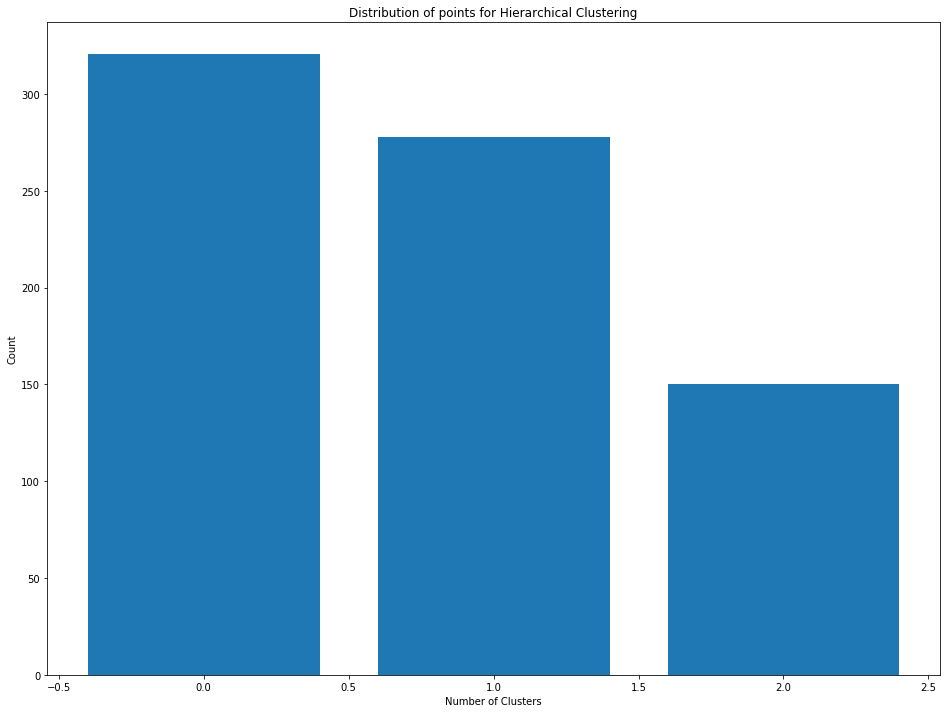

In [39]:
# plotting the cluster distribution
cluster_dist = pd.DataFrame(df.cluster_hierarchical.value_counts())
cluster_dist.reset_index(inplace=True)
cluster_dist.columns = ['cluster_number', 'counts']
plt.bar(cluster_dist.cluster_number, cluster_dist.counts);


# setting the plot labels and title
plt.xlabel("Number of Clusters")
plt.ylabel("Count")
plt.title("Distribution of points for Hierarchical Clustering")

We can see that the score is a bit low for Hierarchical. But KMeans seems promising. So, we'll go with it.

### Part 4: Visualizing the clusters

In [40]:
# copy the dataframe to create binning
vis = df.copy()

# binning for delay
vis['Delay_s_per_km_bin'] = 'average'
vis.loc[vis.Delay_s_per_km < 20, 'Delay_s_per_km_bin'] = 'low'
vis.loc[vis.Delay_s_per_km > 120, 'Delay_s_per_km_bin'] = 'high'

In [41]:
vis.head()

,StopNumber,MonitoredVehicleJourney_DirectionRef,DistanceTraveled_km,Delay_s,EarlyCount,DelayCount,OnTimeCount,Delay_s_per_km,cluster_kmeans,cluster_dbscan,cluster_hierarchical,Delay_s_per_km_bin
0,8,I,2.5780,44.536482,3356,6428,8595,17.275594,1,0,2,low
1,12,I,1.2108,43.395680,9633,18330,25464,37.178352,0,0,0,average
2,14,I,0.5738,85.787101,13849,28756,18222,153.858460,0,0,0,high
3,14,O,0.5360,0.000000,187,522,5268,0.000000,1,0,1,low
4,15,I,0.7226,87.510760,12117,24862,12880,121.105398,0,0,2,high


#### Cluster 1

In [42]:
vis_cluster = vis[vis.cluster_kmeans == 0]

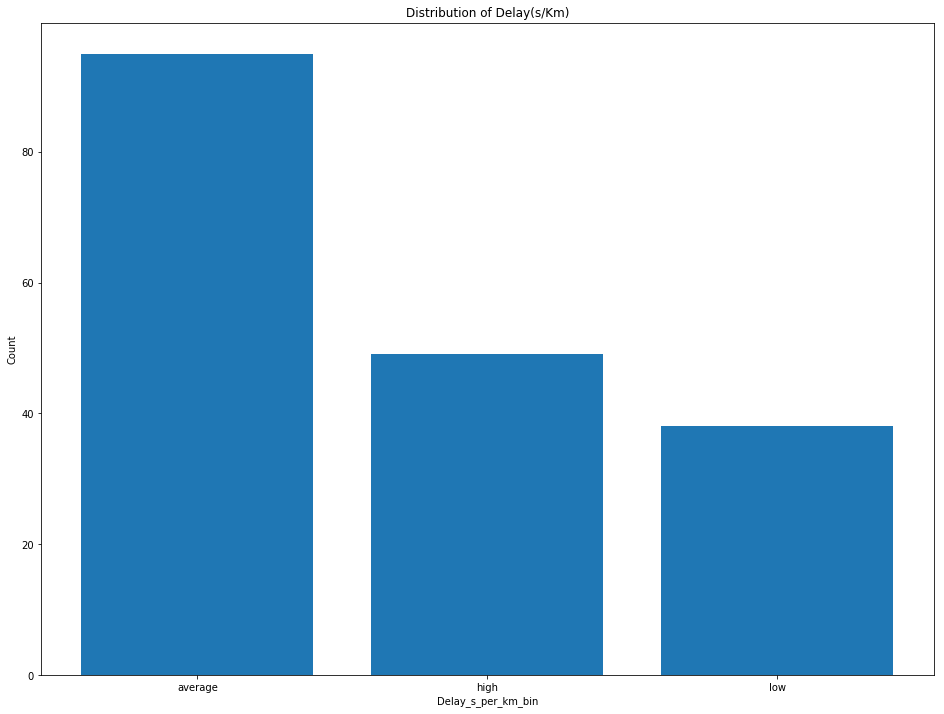

In [43]:
# bar plot for Delay_s
temp = vis_cluster.groupby('Delay_s_per_km_bin').agg('count').iloc[:,0]
plt.bar(temp.index, temp.values);
# set the plot titles and labels
plt.title("Distribution of Delay(s/Km)");
plt.xlabel("Delay_s_per_km_bin");
plt.ylabel("Count");

As we can see that this cluster represents the areas which we can tag as "yellow" zones. They have moderate delays are might not need immediate attention.

#### Cluster 2

In [44]:
vis_cluster = vis[vis.cluster_kmeans == 1]

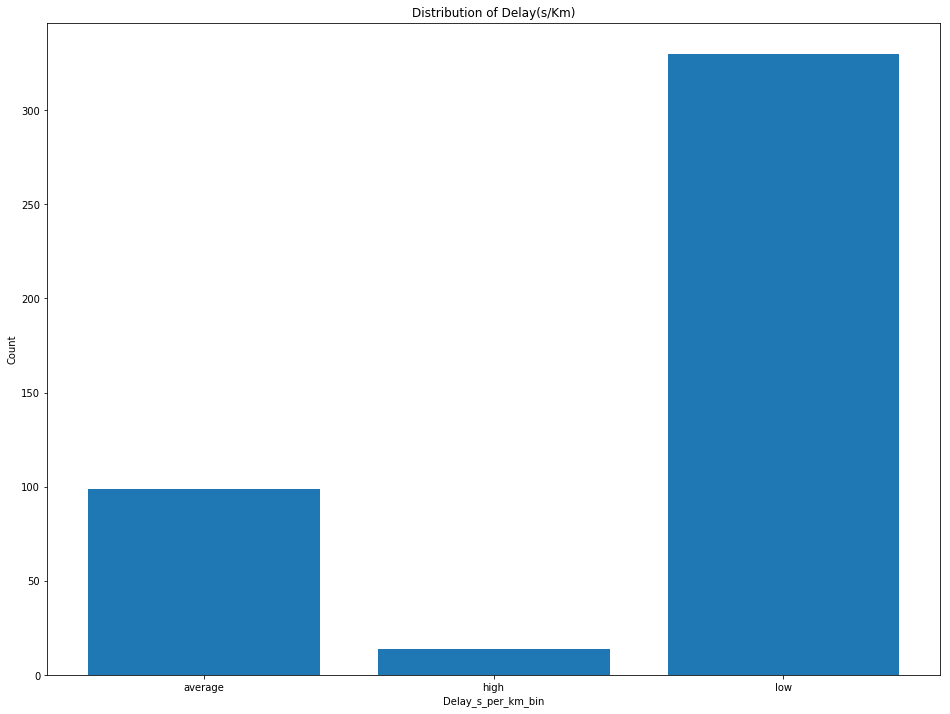

In [45]:
# bar plot for Delay_s
temp = vis_cluster.groupby('Delay_s_per_km_bin').agg('count').iloc[:,0]
plt.bar(temp.index, temp.values)
# set the plot titles and labels
plt.title("Distribution of Delay(s/Km)");
plt.xlabel("Delay_s_per_km_bin");
plt.ylabel("Count");

This cluster seems to capture all the region where there's mild to low delay. These stops can be termed as "green" and is operating in a perfect manner.

#### Cluster 3

In [46]:
vis_cluster = vis[vis.cluster_kmeans == 2]

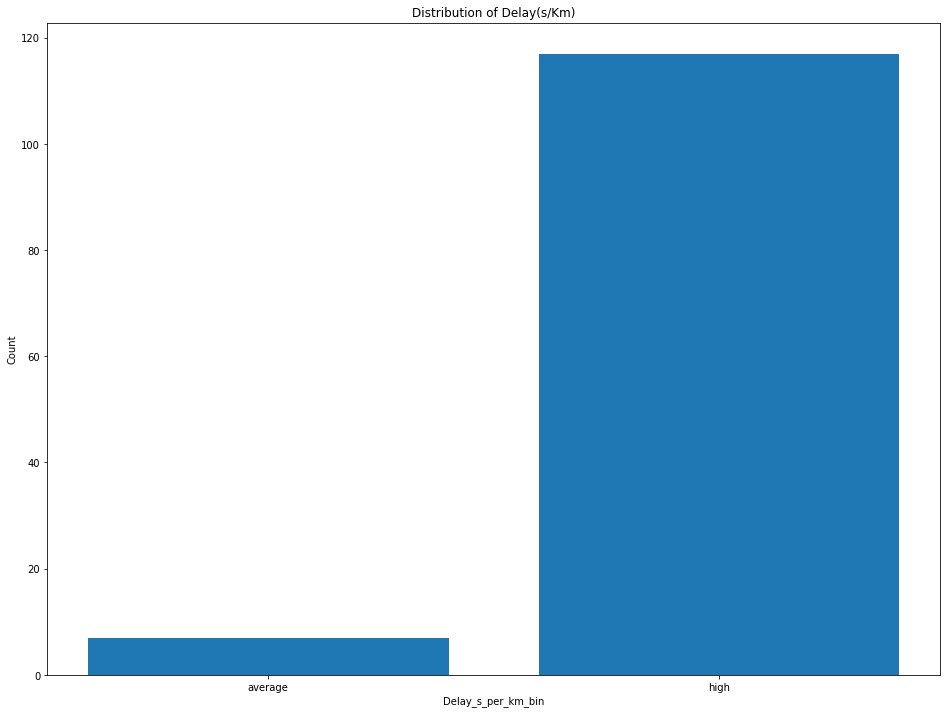

In [47]:
# bar plot for Delay_s
temp = vis_cluster.groupby('Delay_s_per_km_bin').agg('count').iloc[:,0]
plt.bar(temp.index, temp.values)
# set the plot titles and labels
plt.title("Distribution of Delay(s/Km)");
plt.xlabel("Delay_s_per_km_bin");
plt.ylabel("Count");

The upper cluster have caught all the "red" zones. These stops have severe delay in terms of bus arrival and need some attention. We will perform more analysis on this group to get a clear understanding of the traffic pattern.

In [48]:
df.to_csv('clustering.csv', index=False)